In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the initial df
df = pd.read_csv('bitcoin_2017_to_2023.csv')

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
# New column names
old_names = [
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume'
]

new_names = [
    'quote_vol',
    'count',
    'buy_base',
    'buy_quote'
]

# Create a dictionary mapping old column names to new column names
rename_dict = dict(zip(old_names, new_names))

# Rename the columns
df.rename(columns=rename_dict, inplace=True)

In [6]:
# Check the date range
start_date = df['timestamp'].min()
end_date = df['timestamp'].max()
print(f"Date range: {start_date} to {end_date}")
print(f"Nulls found: \n{df.isnull().sum()}")

Date range: 2017-08-17 04:00:00 to 2023-08-01 13:19:00
Nulls found: 
timestamp    0
open         0
high         0
low          0
close        0
volume       0
quote_vol    0
count        0
buy_base     0
buy_quote    0
dtype: int64


In [7]:
# Generate a date range with a minute frequency from start to end date
full_time_range = pd.date_range(start=start_date, end=end_date, freq='min')

# Check for missing timestamps
missing_timestamps = full_time_range.difference(df['timestamp'])

# Display the number of missing timestamps and a sample
print(f"Total timestamps missing: {len(missing_timestamps)}")
print("Sample of missing timestamps:")
print(missing_timestamps[:5])

Total timestamps missing: 8632
Sample of missing timestamps:
DatetimeIndex(['2017-09-06 16:01:00', '2017-09-06 16:02:00',
               '2017-09-06 16:03:00', '2017-09-06 16:04:00',
               '2017-09-06 16:05:00'],
              dtype='datetime64[ns]', freq=None)


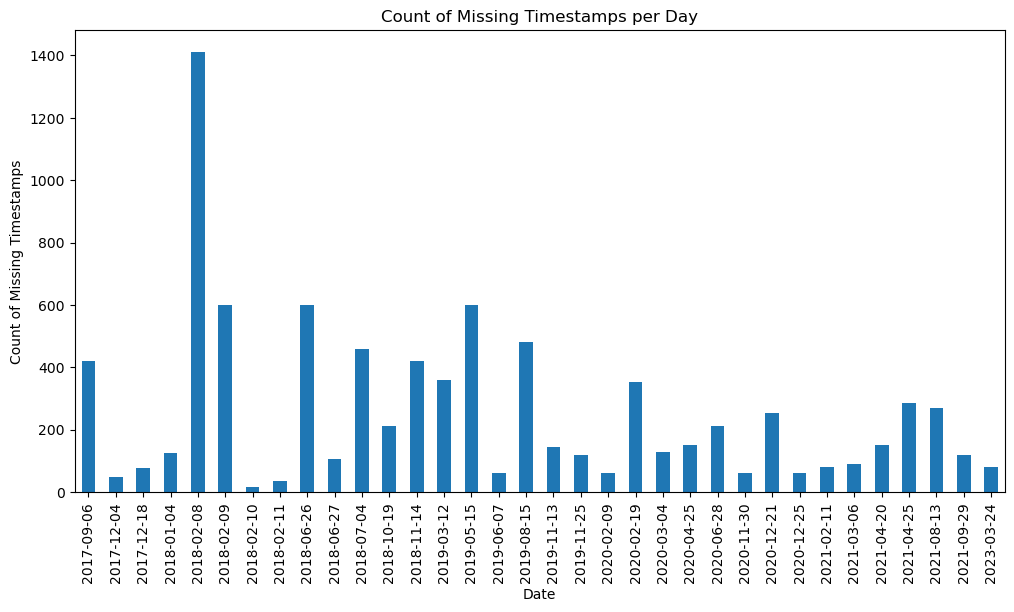

In [8]:
# Create a DataFrame for missing timestamps
missing_df = pd.DataFrame(missing_timestamps, columns=['timestamp'])
missing_df['date'] = missing_df['timestamp'].dt.date

# Count missing timestamps per day
missing_count_per_day = missing_df.groupby('date').size()

# Plot the count of missing timestamps per day
plt.figure(figsize=(12, 6))
missing_count_per_day.plot(kind='bar')
plt.title('Count of Missing Timestamps per Day')
plt.xlabel('Date')
plt.ylabel('Count of Missing Timestamps')
plt.show()

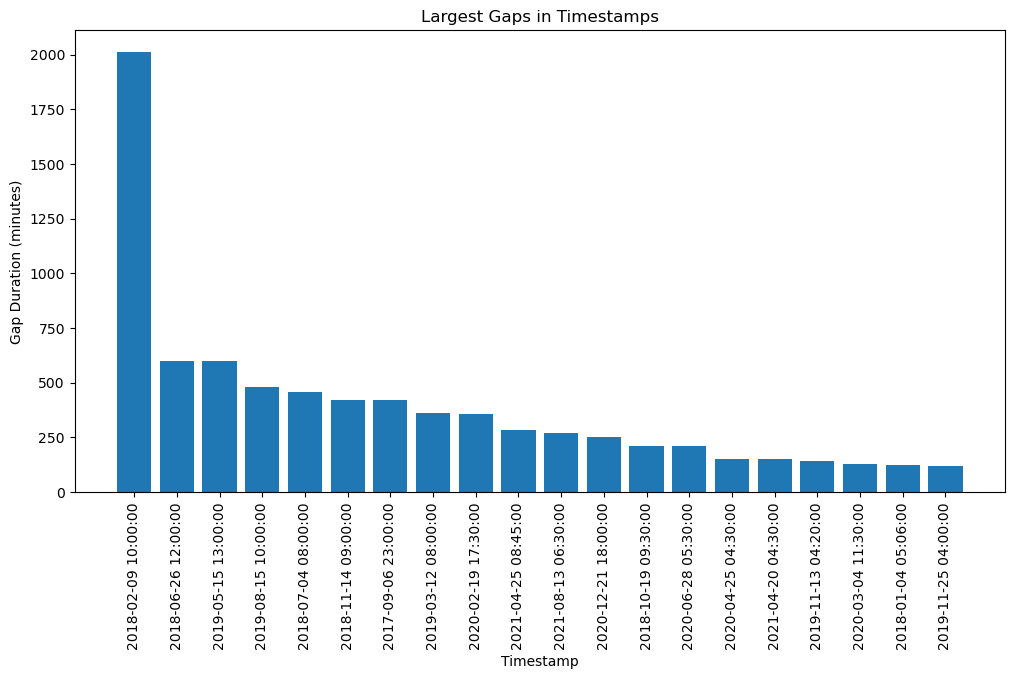

In [10]:
# Sort the DataFrame by timestamp
df.sort_values('timestamp', inplace=True)

# Calculate the differences between consecutive timestamps
df['time_diff'] = df['timestamp'].diff()

# Find the largest gaps
largest_gaps = df.nlargest(20, 'time_diff')

# Plot the largest gaps
plt.figure(figsize=(12, 6))
plt.bar(largest_gaps['timestamp'].astype(str), largest_gaps['time_diff'].dt.total_seconds() / 60)
plt.title('Largest Gaps in Timestamps')
plt.xlabel('Timestamp')
plt.ylabel('Gap Duration (minutes)')
plt.xticks(rotation=90)
plt.show()

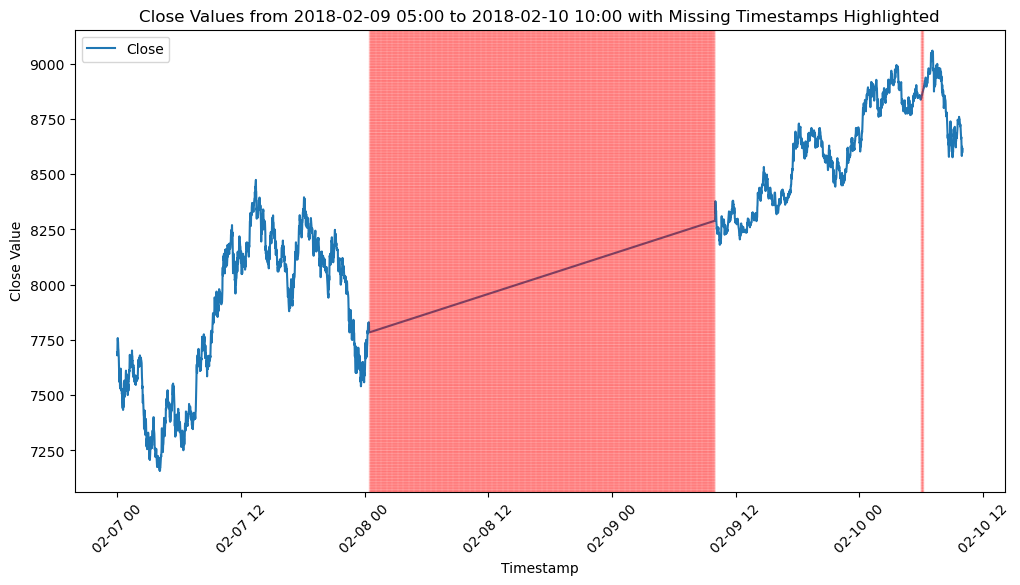

In [11]:
# Define the time range
start_time = pd.Timestamp('2018-02-07 00:00:00')
end_time = pd.Timestamp('2018-02-10 10:00:00')

# Filter the DataFrame to include data within the specified range
df_filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

# Generate a full date range with a minute frequency within the specified range
full_time_range = pd.date_range(start=start_time, end=end_time, freq='min')

# Identify missing timestamps
missing_timestamps = full_time_range.difference(df_filtered['timestamp'])

# Plot the 'close' values within the specified time range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['timestamp'], df_filtered['close'], linestyle='-', label='Close')

# Plot the missing timestamps as red markers
for missing in missing_timestamps:
    plt.axvline(missing, color='red', linestyle='--', linewidth=0.1)

plt.title('Close Values from 2018-02-09 05:00 to 2018-02-10 10:00 with Missing Timestamps Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Close Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [12]:
# Set the timestamp column as the index
df.set_index('timestamp', inplace=True)

# Sort the DataFrame by the index (timestamp) in ascending order
df.sort_index(inplace=True)

# Remove duplicates from the index
df = df[~df.index.duplicated(keep='first')]

# Generate a full date range with a minute frequency
full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')

# Reindex the DataFrame to include the full time range, filling missing values with NaNs
df = df.reindex(full_time_range)

# Interpolate the missing 'close' values linearly
df = df.interpolate(method='linear')

# Reset the index to make 'timestamp' a column again
df.reset_index(inplace=True)
df.rename(columns={'index': 'timestamp'}, inplace=True)

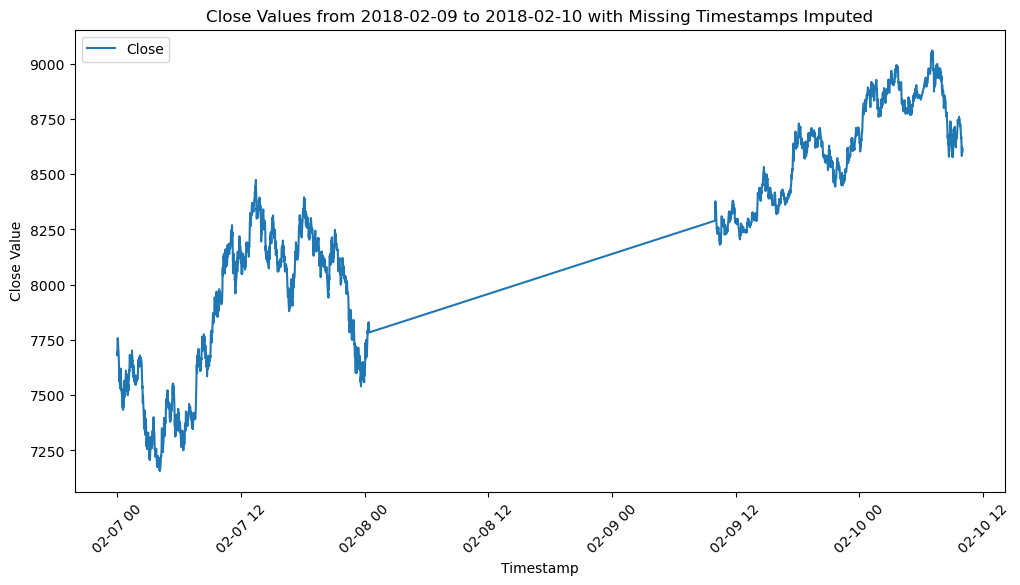

In [13]:
# Plot the 'close' values within the specified time range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['timestamp'], df_filtered['close'], linestyle='-', label='Close')
plt.title('Close Values from 2018-02-09 to 2018-02-10 with Missing Timestamps Imputed')
plt.xlabel('Timestamp')
plt.ylabel('Close Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [14]:
# Rename 'timestamp' to 'open_time'
df.rename(columns={'timestamp': 'open_time'}, inplace=True)

# Create a new 'close_time' column that is 'open_time' + 1 minute
df['close_time'] = df['open_time'] + pd.Timedelta(minutes=1)

# Save cleaned dataframe to CSV
df.to_csv("BTC_1min_clean.csv", index=False)